# Plot abrupt4xCO2 anomalies and fit linear response

In [4]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
import pandas as pd
import os

from scipy import optimize
import random as rd

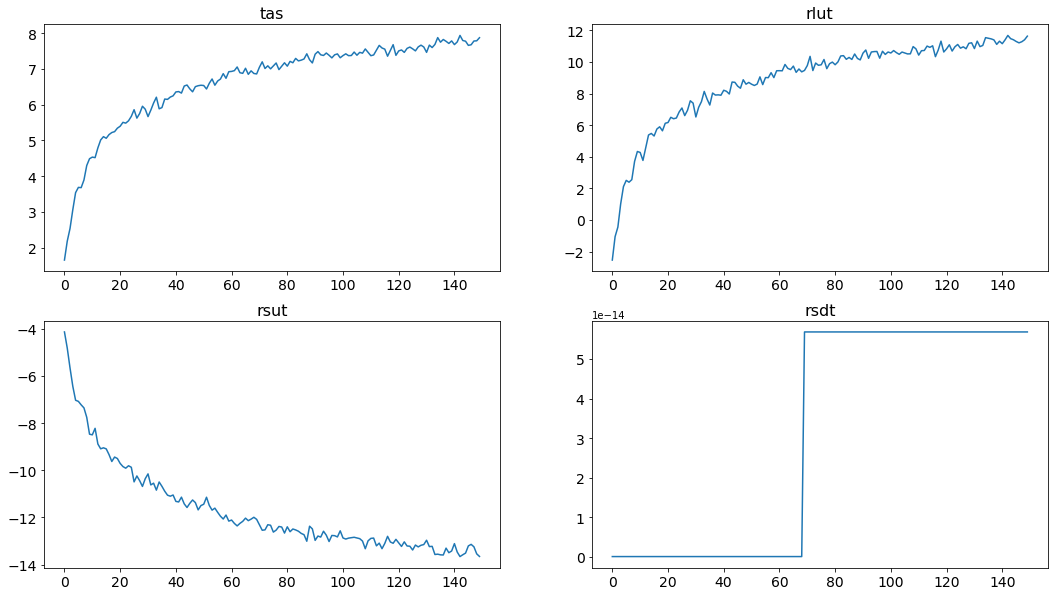

In [92]:
model = 'UKESM1-0-LL'

exp = 'abrupt-4xCO2'
member = 'r1i1p1f2'

filename = model + '_' + exp + '_' + member + '_anomalies.txt'
file = os.path.join('../Processed_data/Global_annual_anomalies/', model, exp, filename)

data = pd.read_table(file, index_col=0, sep = ',')
data = data.dropna()
if exp == 'abrupt-2xCO2': # "convert to 4xCO2" by multiplying by 2
    data *= 2
elif exp == 'abrupt-0p5xCO2': # "convert to 4xCO2" by multiplying by -2
    data *= -2
x = data.index.values

# plot each variable:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = [18,10]); axes = np.reshape(ax, 4)
for (i,var) in enumerate(['tas', 'rlut', 'rsut', 'rsdt']):
    axes[i].plot(x, data[var])
    axes[i].set_title(var, fontsize = 16)
    axes[i].tick_params(axis='both',labelsize=14)


Linear fit to the first 150 years gives:
F2xCO2 = 3.6577643303559917
feedback parameter = -0.6792737070234381
ECS / T2xCO2 = 5.384816595337146


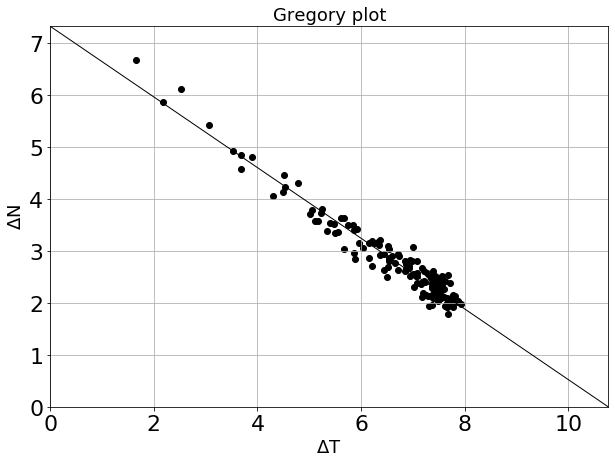

In [93]:
# Gregory plot
fig, ax = plt.subplots(figsize = [10,7])

deltaN = data['rsdt'] - data['rsut'] - data['rlut']
deltaT = data['tas']

deltaT = deltaT[:150]; deltaN = deltaN[:150] # if data is longer than 150 years, use only the first 150 years
ax.scatter(deltaT, deltaN,linewidth=1,color = "black")
ax.set_xlabel('$\Delta$T',fontsize = 18)
ax.set_ylabel('$\Delta$N',fontsize = 18)
ax.set_title('Gregory plot',fontsize = 18)
ax.grid()
ax.tick_params(axis='both',labelsize=22)  

# find linear fit to these points:
p1 = np.polyfit(deltaT, deltaN, deg = 1)
print('Linear fit to the first 150 years gives:')
print('F2xCO2 = '+ str(p1[1]/2))
print('feedback parameter = ' + str(p1[0]))
print('ECS / T2xCO2 = ' + str(-p1[1]/(2*p1[0])))
deltaTextended = np.concatenate(([0],deltaT,[-p1[1]/p1[0]]))
linfit = np.polyval(p1,deltaTextended)
plt.plot(deltaTextended,linfit,linewidth=1,color = "black")

ax.set_ylim(0,p1[1])
ax.set_xlim(0,-p1[1]/(p1[0]));

## Compute 1000 different fits

In [94]:
years = np.arange(1,150+1)

N = 1000;
p_lim = 1 - 0.99;

parameters_names = ['tau1', 'tau2', 'tau3', 'tau4', 'a_1', 'a_2', 'a_3', 'a_4', 'b_1', 'b_2', 'b_3', 'b_4', 'F2x', 'T2x','rnorm']
df_par = pd.DataFrame(columns=parameters_names)

# for deltaT we also have the information that deltaT(0) = 0. Include this:
deltaT0 = np.concatenate(([0],deltaT))
years0 = np.concatenate(([0],years))
timepoints = np.arange(0,151)

# for loop with different random choices of time scales:
ii = 0
while ii < 1000:
    # the log10 of the time scale will be the random number:
    tau1 = 10**rd.uniform(np.log10(1), np.log10(6)) # range: (1, 6) years
    factor1 = rd.uniform(5,10); factor2 = rd.uniform(10,80);
    tau2 = factor1*tau1; #tau3 = factor2*tau2
    tau3 = 10**rd.uniform(np.log10(80), np.log10(1000))
    
    # fixed time scales:
    taulist = np.array([tau1, tau2, tau3])
    dim = len(taulist) 
    # compute components T_n(t) = exp(-t/tau_n)*F(t) (Here * is a convolution and F is a constant, so we can compute T_n analytically)
    A = np.zeros((len(years)+1,dim))
    for i in range(0,dim): # compute the predictors in the linear model for deltaT
        A[:,i] = (1 - np.exp((-np.arange(0,151))/taulist[i]))
    
    ########### find parameters a_n in the linear model: deltaT = \sum_i a_n[i]*(1 - np.exp((-t/tau[i])) ###########
    a_n, rnorm1 = optimize.nnls(A,deltaT0) # non-negative least squares, to ensure positive parameters
    Ti = np.array([A[:,i]*a_n[i] for i in range(0,dim)]) # compute components
    Tsum = A@a_n # sum of all components
    
    ########### Next: Estimate the lambda's from a Gregory plot ###########

    # include lines dividing the regions where the different fits will be made
    splits = np.cumsum(a_n)
    
    if deltaT0[-10] < splits[dim-2]: # require at least 10 points to make a regression
        continue

    # First: Linear fit to the part of Gregory plot dominated by the slowest mode:
    p_lim_index3 = np.int(np.ceil(-tau3*np.log(p_lim)))-1 # -1 because index 0 is year 1
    T3 = deltaT[deltaT>=splits[dim-2]]
    N3 = deltaN[-len(T3):]
    reg_endindex3 = np.min([p_lim_index3 - (len(deltaT)-len(T3)), len(T3)]);
    reg3par = np.polyfit(T3[:reg_endindex3],N3[:reg_endindex3],deg = 1)
    b_4 = reg3par[1] + reg3par[0]*np.sum(a_n) # also equal to lambda3*a_4, and 2*(newF2x - oldF2x)
    lambda3 = - reg3par[0]
    newECS = -reg3par[1]/reg3par[0]/2
    oldECS = sum(a_n)/2
    a_4 = 2*(newECS - oldECS) # extra temperature rise seen in Gregory plot
    #print(newECS*2, sum(a_n) + a_4)
    
    # need to include the "invisible" even longer time scale for this to work:
    tau4 = 5000;
    T4 = a_4*(1 - np.exp(-timepoints/tau4))
    N4 = b_4*np.exp(-timepoints/tau4)
    rnorm2 = np.linalg.norm(Tsum + T4 - deltaT0) #,ord=2 ### A@a_n - deltaT0
    #rnormlist2[ii] = rnorm2
    
    if newECS*2 < np.sum(a_n):
        #print('continued1')
        continue
    elif rnorm2 > rnorm1*1.1:
        #print('continued2')
        continue

    T3ext = np.append(T3, newECS*2);
    linfit3 = np.polyval(reg3par,T3ext)
    
    # Second: Linear fit to part of second "Gregory plot" dominated by intermediate (decadal-scale) mode:
    T_3 = Ti[-1,1:]; N_3 = (lambda3*(a_n[-1] - T_3))
    deltaT2 = deltaT - T_3; deltaN2 = deltaN - N_3 - b_4
    T2 = deltaT2[deltaT2>=splits[dim-3]] 
    N2 = deltaN2[-len(T2):]
    dT2 = splits[dim-2] - T2 # make dT2 a mirror of T2, and starting in 0, just for parameter estimation
    p_lim_index2 = np.int(np.ceil(-tau2*np.log(p_lim)))-1 # -1 because index 0 is year 1
    reg_endindex2 = np.min([p_lim_index2 - (len(deltaT)-len(dT2)), len(dT2)]);
    if reg_endindex2 < 2:
        #print('test')
        reg_endindex2 = 3
    
    # this will be a linear model: N2 = slope * dT2 (with no constant term)
    ls_sol2, res, rank, sing_vals = np.linalg.lstsq(np.array([dT2[:reg_endindex2]]).T, np.array([N2[:reg_endindex2]]).T, rcond=None)
    T2ext = np.array([np.concatenate(([splits[0]], T2, [splits[dim-2]]))]).T
    linfit2 = - T2ext@ls_sol2 + splits[dim-2]*ls_sol2[0,0]

    # Third: Linear fit to the part of "Gregory plot" dominated by first mode:
    lambda2 = ls_sol2[0,0]
    T_2 = Ti[-2,1:]; N_2 = (lambda2*(a_n[-2] - T_2))
    deltaT1 = deltaT2 - T_2; deltaN1 = deltaN2 - N_2
    T1 = deltaT1 # use all points
    N1 = deltaN1
    dT1 = splits[0] - T1
    p_lim_index1 = np.int(np.ceil(-tau1*np.log(p_lim)))-1 # -1 because index 0 is year 1
    reg_endindex1 = np.min([p_lim_index1 - (len(deltaT)-len(dT1)), len(dT1)]);
    
    # this will be a linear model: dN2 = slope * dT2 (with no constant term)
    ls_sol1, res, rank, sing_vals = np.linalg.lstsq(np.array([dT1[:reg_endindex1]]).T, np.array([N1[:reg_endindex1]]).T, rcond=None)
    T1ext = np.array([np.concatenate(([0],T1, [splits[0]]))]).T
    linfit1 = - T1ext@ls_sol1 + splits[0]*ls_sol1[0,0]

    # put all estimated lambdas in array, and estimate b_n:
    lambdas = np.array([ls_sol1[0,0], ls_sol2[0,0], - reg3par[0]])
    b_n = lambdas*a_n

    ######### Compute components of N from already estimated paramters: ######### 
    A4 = np.zeros((len(years0),dim))
    for i in range(0,dim): # compute the predictors in the linear model for deltaN  
        A4[:,i] = np.exp((-years0)/taulist[i])    

    Ni = np.array([A4[:,i]*b_n[i] for i in range(0,dim)]) # compute components
    Nsum = A4@b_n # sum of all components   

    # add extra mode, and then extra point in equilibrium:
    Tsum += T4; Tsumext = np.append(Tsum, 2*newECS)
    Nsum += N4; Nsumext = np.append(Nsum, 0)
    newF2x = Nsumext[0]/2
    
    # write results to table
    pars = np.concatenate((taulist, tau4, a_n, a_4, b_n, b_4, newF2x, newECS, rnorm1), axis=None)
    df_par = df_par.append(pd.DataFrame([pars], columns=parameters_names), ignore_index=True)
    ii += 1;

#print(df_par,sep="\n");

In [95]:
# save file

if exp == 'abrupt-4xCO2':
    modelfilename = model + '_' + member + '_1000parameters.txt' # shortest time scale 1-6 yrs
    df_par.to_csv('../Estimates/1000parameters_4xCO2/' + modelfilename, sep='\t')
else:
    modelfilename = model + '_' + exp + '_' + member + '_1000parameters.txt' # shortest time scale 1-6 yrs
    if exp == 'abrupt-2xCO2':
        df_par.to_csv('../Estimates/1000parameters_2xCO2/' + modelfilename, sep='\t')
    elif exp == 'abrupt-0p5xCO2':
        df_par.to_csv('../Estimates/1000parameters_0p5xCO2/' + modelfilename, sep='\t')


# Plot results

Best estimate:
lambdas:[1.02596578 0.68263717 0.62941795]
New F2x = 4.123154792508764
Temperature only estimate of T2x / ECS = 4.192528682942619
New estimate of T2x / ECS = 5.5345801237157275

Ordinary Gregory estimates:
F2xCO2 = 3.6577643303559917
feedback parameter = -0.6792737070234381
ECS / T2xCO2 = 5.384816595337146


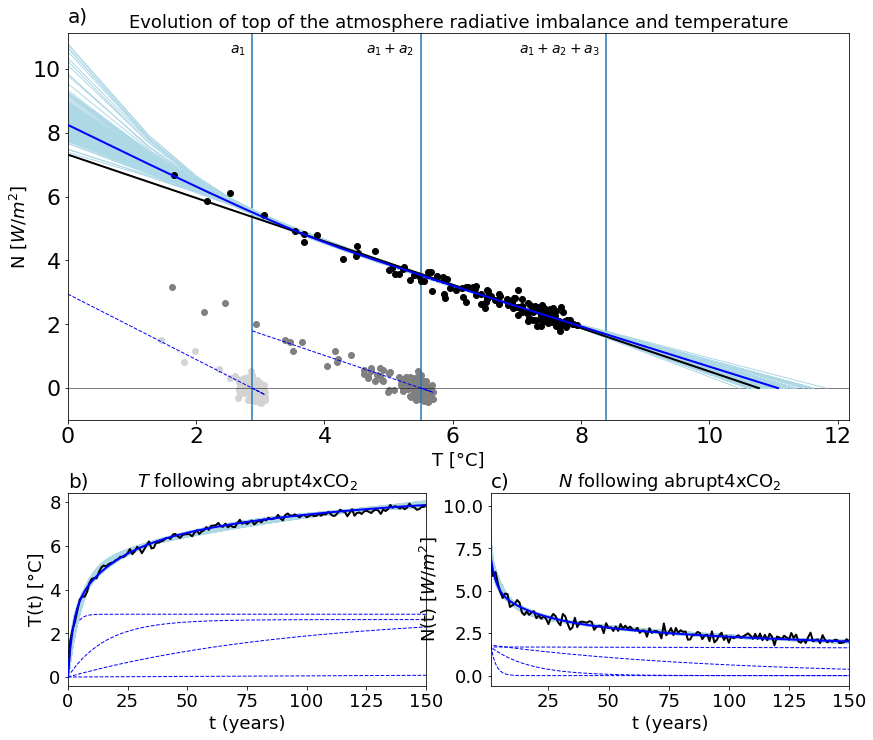

In [96]:
# load file if needed
#filename = model + '_' + member + '_1000parameters.txt'
#df_par = pd.read_table('../Estimates/1000parameters_4xCO2/' + filename,index_col=0)

N = len(df_par)
p_lim = 1 - 0.99;

deltaT0 = np.concatenate(([0],deltaT))
years0 = np.concatenate(([0],years))
timepoints = np.arange(0,151)

fig = plt.figure(figsize = [14,12]); #widths = [16, 16]
import matplotlib.gridspec as gridspec
#make outer gridspec
outer = gridspec.GridSpec(2, 1, height_ratios = [2, 1],  hspace = 0.25) 
#make nested gridspecs
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0], hspace = 0.1)
#gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = outer[1], wspace = 0.15)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = outer[1], wspace = 0.18)

Gax = fig.add_subplot(gs1[0])
Tax = fig.add_subplot(gs2[0])
Nax = fig.add_subplot(gs2[1])

# find maximum values that need to be plotted
T2x_max = np.max(df_par.loc[:,'T2x'])
F2x_max = np.max(df_par.loc[:,'F2x'])

Gax.set_xlabel('T [°C]',fontsize = 18)
Gax.set_ylabel('N [$W/m^2$]',fontsize = 18)
Gax.set_title('Evolution of top of the atmosphere radiative imbalance and temperature',fontsize = 18)
Gax.axhline(0, color='k', linewidth = 0.5) # horizontal lines
Gax.set_xlim([0, 2*T2x_max*1.03])
Gax.set_ylim([-1, 2*F2x_max*1.03])
Gax.tick_params(axis='both',labelsize=22)  

# create figure
Tax.set_xlabel('t (years)',fontsize = 18)
Tax.set_ylabel('T(t) [°C]',fontsize = 18)
Tax.set_title('$T$ following abrupt4xCO$_2$',fontsize = 18)
Tax.set_xlim(min(years0),max(years0))
Tax.tick_params(axis='both',labelsize=18)

# plot control net TOA rad
Nax.set_xlabel('t (years)',fontsize = 18)
Nax.set_ylabel('N(t) [$W/m^2$]',fontsize = 18)
Nax.set_title('$N$ following abrupt4xCO$_2$',fontsize = 18)
Nax.set_xlim(min(years),max(years))
Nax.set_ylim(-0.6,2*F2x_max)
Nax.tick_params(axis='both',labelsize=18)

best_rnorm = np.min(df_par['rnorm']);
for ii in range(N):
    # load parameters from dataframe:
    taulist = np.array(df_par.loc[ii,'tau1':'tau4'])
    a_n = np.array(df_par.loc[ii,'a_1':'a_4'])
    b_n = np.array(df_par.loc[ii,'b_1':'b_4'])
    F2x = df_par.loc[ii,'F2x']
    T2x = df_par.loc[ii,'T2x']
    rnorm = df_par.loc[ii,'rnorm']
    
    dim = len(taulist) 
    ######### compute components of T from already estimated parameters: #########
    A = np.zeros((len(years)+1,dim))
    for i in range(0,dim): # compute the predictors in the linear model for deltaT
        A[:,i] = (1 - np.exp((-np.arange(0,151))/taulist[i]))
    Ti = np.array([A[:,i]*a_n[i] for i in range(0,dim)]) # compute components
    Tsum = A@a_n # sum of all components
    
    ######### Compute components of N from already estimated paramters: ######### 
    A4 = np.zeros((len(years0),dim))
    for i in range(0,dim): # compute the predictors in the linear model for deltaN  
        A4[:,i] = np.exp((-years0)/taulist[i])    
    Ni = np.array([A4[:,i]*b_n[i] for i in range(0,dim)]) # compute components
    Nsum = A4@b_n # sum of all components   

    # add extra point in equilibrium:
    Tsumext = np.append(Tsum, 2*T2x)
    Nsumext = np.append(Nsum, 0)
    
    Gax.plot(Tsumext,Nsumext,linewidth=1,color = "lightblue");
    Tax.plot(years0,Tsum,linewidth=2,color = "lightblue")
    Nax.plot(years0,Nsum,linewidth=2,color = "lightblue")
    
    if rnorm == best_rnorm:
        print('Best estimate:')
        splits = np.cumsum(a_n[:dim-1])
        for splitline in splits:
            Gax.axvline(x=splitline)
        Gax.text(splits[0]-0.1, 2*F2x_max-0.3, '$a_1$', fontsize = 14, horizontalalignment='right')
        Gax.text(splits[1]-0.1, 2*F2x_max-0.3, '$a_1 + a_2$', fontsize = 14, horizontalalignment='right')
        Gax.text(splits[2]-0.1, 2*F2x_max-0.3, '$a_1 + a_2 + a_3$', fontsize = 14, horizontalalignment='right')
        
        # recompute a few things to be plotted only for the best fit:
        b_4 = b_n[-1]; a_n = a_n[0:dim-1]; b_n = b_n[0:dim-1]; dim = dim - 1; # change to same notation as in estimation (except for Ti)
        tau1 = taulist[0]; tau2 = taulist[1]; tau3 = taulist[2]
        
        # First: Linear fit to the part of Gregory plot dominated by the slowest mode:
        p_lim_index3 = np.int(np.ceil(-tau3*np.log(p_lim)))-1 # -1 because index 0 is year 1
        T3 = deltaT[deltaT>=splits[dim-2]]
        N3 = deltaN[-len(T3):]
        reg_endindex3 = np.min([p_lim_index3 - (len(deltaT)-len(T3)), len(T3)]);
        reg3par = np.polyfit(T3[:reg_endindex3],N3[:reg_endindex3],deg = 1)
        T3ext = np.append(T3, T2x*2);
        linfit3 = np.polyval(reg3par,T3ext)
        
        # Second: Linear fit to part of second "Gregory plot" dominated by intermediate (decadal-scale) mode:
        T_3 = Ti[2,1:]; N_3 = (- reg3par[0]*(a_n[-1] - T_3))
        deltaT2 = deltaT - T_3; deltaN2 = deltaN - N_3 - b_4
        T2 = deltaT2[deltaT2>=splits[dim-3]] 
        N2 = deltaN2[-len(T2):]
        dT2 = splits[dim-2] - T2 # make dT2 a mirror of T2, and starting in 0, just for parameter estimation
        p_lim_index2 = np.int(np.ceil(-tau2*np.log(p_lim)))-1 # -1 because index 0 is year 1
        reg_endindex2 = np.min([p_lim_index2 - (len(deltaT)-len(dT2)), len(dT2)]);
        if reg_endindex2 < 3:
            reg_endindex2 = 3 # make sure we still use at least 3 points

        # this will be a linear model: N2 = slope * dT2 (with no constant term)
        ls_sol2, res, rank, sing_vals = np.linalg.lstsq(np.array([dT2[:reg_endindex2]]).T, np.array([N2[:reg_endindex2]]).T, rcond=None)
        T2ext = np.array([np.concatenate(([splits[0]], T2, [splits[dim-2]]))]).T
        linfit2 = - T2ext@ls_sol2 + splits[dim-2]*ls_sol2[0,0]

        # Third: Linear fit to the part of "Gregory plot" dominated by first mode:
        lambda2 = ls_sol2[0,0]
        T_2 = Ti[1,1:]; N_2 = (lambda2*(a_n[-2] - T_2))
        deltaT1 = deltaT2 - T_2; deltaN1 = deltaN2 - N_2
        T1 = deltaT1 # use all points
        N1 = deltaN1
        dT1 = splits[0] - T1
        p_lim_index1 = np.int(np.ceil(-tau1*np.log(p_lim)))-1 # -1 because index 0 is year 1
        reg_endindex1 = np.min([p_lim_index1 - (len(deltaT)-len(dT1)), len(dT1)]);

        # this will be a linear model: dN2 = slope * dT2 (with no constant term)
        ls_sol1, res, rank, sing_vals = np.linalg.lstsq(np.array([dT1[:reg_endindex1]]).T, np.array([N1[:reg_endindex1]]).T, rcond=None)
        T1ext = np.array([np.concatenate(([0],T1, [splits[0]]))]).T
        linfit1 = - T1ext@ls_sol1 + splits[0]*ls_sol1[0,0]

            
        # linear fits shown as dashed blue curves, and gray dots that are used to compute the fit:
        Gax.plot(T3ext, linfit3, '--', linewidth=1, color = "blue",zorder=1000)
        Gax.scatter(deltaT2,deltaN2,linewidth=1,color = "gray")
        if a_n[1]>0:
            Gax.plot(T2ext, linfit2, '--', linewidth=1, color = "blue")
        Gax.scatter(deltaT1,deltaN1,linewidth=1,color = "lightgray")
        Gax.plot(T1ext, linfit1, '--', linewidth=1, color = "blue")
        
        Gax.plot(Tsumext,Nsumext,linewidth=2,color = "blue",zorder=1000);
        Tax.plot(years0,Tsum,linewidth=2,color = "blue",zorder=1000)
        Nax.plot(years0,Nsum,linewidth=2,color = "blue",zorder=1000)
        
        Gax.scatter(deltaT,deltaN,linewidth=1,color = "black",zorder=999)
        Tax.plot(years0,deltaT0,linewidth=2,color = "black",zorder=999)
        Nax.plot(years,deltaN,linewidth=2,color = "black",zorder=999)
        
        # plot components of best fit:
        for i in range(0,dim+1):
            Tax.plot(years0,Ti[i,:],'--',linewidth=1,color = "blue")
            Nax.plot(years0,Ni[i,:],'--',linewidth=1,color = "blue")
            
        lambdas = b_n/a_n
        print('lambdas:' + str(lambdas))
        print('New F2x = ' + str(F2x))
        print('Temperature only estimate of T2x / ECS = ' + str(np.sum(a_n[:dim])/2))
        print('New estimate of T2x / ECS = ' + str(T2x) + '\n')
        
        # compute also parameters using ordinary Gregory method:
        p1 = np.polyfit(deltaT,deltaN,deg = 1)
        deltaTextended = np.concatenate(([0],deltaT,[-p1[1]/p1[0]]))
        linfit = np.polyval(p1,deltaTextended)
        GregoryF2x = p1[1]/2; GregoryT2x = -p1[1]/(2*p1[0])
        
        # put results in pandas dataframe:
        taulist = np.array(df_par.loc[ii,'tau1':'tau4'])
        a_n = np.array(df_par.loc[ii,'a_1':'a_4'])
        b_n = np.array(df_par.loc[ii,'b_1':'b_4'])
        columnnames = ['tau1', 'tau2', 'tau3', 'tau4', 'a_1', 'a_2', 'a_3', 'a_4', 'b_1', 'b_2', 'b_3', 'b_4', 'F2x', 'T2x', 'GregoryF2x', 'GregoryT2x'];
        dataframe = pd.DataFrame([np.concatenate((taulist, a_n, b_n, F2x, T2x, GregoryF2x, GregoryT2x), axis=None)], index = [model], columns=columnnames)

        # if file is not already created, create a new file to store the results in:
        filename = 'best_estimated_parameters.txt'
        #dataframe.to_csv('../Estimates/' + filename, sep='\t')
        
        # if file exists already, load instead exising file and append results: 
        loaded_dataframe = pd.read_table('../Estimates/' + filename,index_col=0)
        if (loaded_dataframe.index == model).any():
            loaded_dataframe = loaded_dataframe.drop([model]) # if model already has a row that I want to remove
        loaded_dataframe = loaded_dataframe.append(dataframe)

        # write them to a file:
        if exp == 'abrupt-4xCO2' and member in ['r1i1p1f1', 'r1i1p1f2']: # keep only first member of 4xCO2 right now
            loaded_dataframe.to_csv('../Estimates/' + filename, sep='\t')

        
Gax.plot(deltaTextended,linfit,linewidth=2,color = "black");
print('Ordinary Gregory estimates:')
print('F2xCO2 = '+ str(GregoryF2x))
print('feedback parameter = ' + str(p1[0]))
print('ECS / T2xCO2 = ' + str(GregoryT2x))
        
# include a), b), c):
Gax.text(0,1.03,'a)',transform=Gax.transAxes, fontsize=20)
Tax.text(0,1.03,'b)',transform=Tax.transAxes, fontsize=20)
Nax.text(0,1.03,'c)',transform=Nax.transAxes, fontsize=20);

if exp != 'abrupt-4xCO2': # then specify exp
    plt.savefig('../Figures/' + model + '_' + exp + '_' + member + '_gregory_linresponses.pdf', format='pdf', dpi=600, bbox_inches="tight")
else:
    plt.savefig('../Figures/' + model + '_' + member + '_gregory_linresponses.pdf', format='pdf', dpi=600, bbox_inches="tight")
# if second mode has zero amplitude (a_n[1]==0), then remove this mode from linear model